# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [111]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast 
from math import ceil
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [112]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [113]:
print(azdias.head())
print(azdias.describe())
print('azdias shape: {}'.format(azdias.shape))

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                     

In [114]:
print(feat_info.head())
print(feat_info.describe())
print('feat_info shape: {}'.format(feat_info.shape))

              attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]
       attribute information_level     type missing_or_unknown
count         85                85       85                 85
unique        85                 9        5                  9
top     BALLRAUM            person  ordinal               [-1]
freq           1                43       49                 26
feat_info shape: (85, 4)


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [115]:
# Identify missing or unknown data values and convert them to NaNs.
for index, row in feat_info.iterrows():
    s = row['missing_or_unknown'][1:-1]
    if not s: 
        l = list(s)
    else:
        l = s.split(',')
    for val in l:
        if val == 'X' or val == 'XX':
            azdias[row['attribute']].replace(val, np.NaN, inplace=True)
        else:
            azdias[row['attribute']].replace(ast.literal_eval(val), np.NaN, inplace=True)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

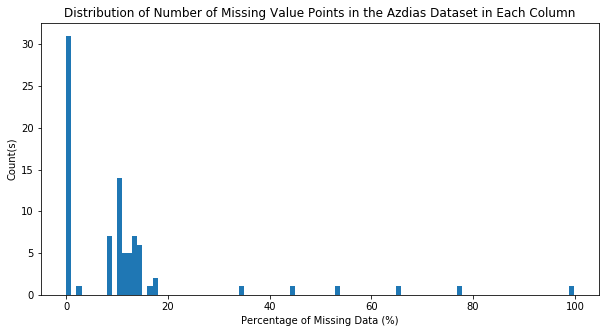

In [116]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null_number = azdias.isnull().sum()

plt.figure(figsize=(10, 5))
plt.title('Distribution of Number of Missing Value Points in the Azdias Dataset in Each Column')
plt.hist(null_number / azdias.shape[0] * 100, bins=100)
plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Count(s)')
plt.show()

In [117]:
# Investigate patterns in the amount of missing data in each column.
data_under_20 = (null_number / len(azdias) * 100) <= 20
data_over_20 = (null_number / len(azdias) * 100) > 20
attri_over_20 = null_number.loc[(null_number / azdias.shape[0] * 100) > 20]
print("Attributes with equal to or under 20% of missing data: {}".format(data_under_20.sum()))
print("Attributes with over 20% of missing data: {}".format(data_over_20.sum()))
print("Attributes with missing data that exceeds 20%: \n{}".format(attri_over_20 / azdias.shape[0] * 100))

Attributes with equal to or under 20% of missing data: 79
Attributes with over 20% of missing data: 6
Attributes with missing data that exceeds 20%: 
AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64


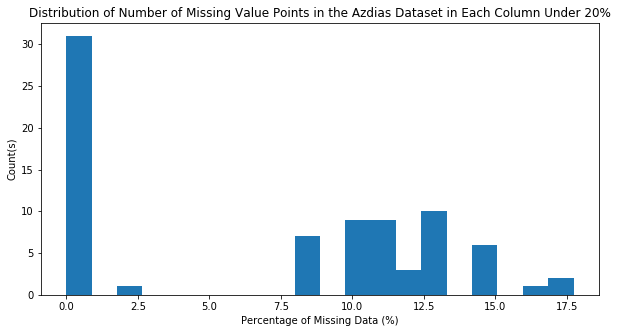

In [118]:
# Plot distribution of missing data under 20% in each column/attribute
plt.figure(figsize=(10, 5))
plt.title('Distribution of Number of Missing Value Points in the Azdias Dataset in Each Column Under 20%')
azdias_filtered = null_number.loc[(null_number / azdias.shape[0] * 100) <= 20]
plt.hist(azdias_filtered / azdias.shape[0] * 100, bins=20)
plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Count(s)')
plt.show()

In [119]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias = azdias.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis=1)

#### Discussion 1.1.2: Assess Missing Data in Each Column

As you can see from the distribution histogram I plotted in the first cell of step 1.1.2, we can see how the majority of the columns/attributes have less than 20% of missing data, 79 attributes to be exact, because of how dense the histogram is under 20% of missing data. Thus, setting 20% as the threshold to spot the outliers, I dropped a total of 6 attributes that exceed 20% of missing data from the dataset: "AGER_TYP", "GEBURTSJAHR", "TITEL_KZ", "ALTER_HH", "KK_KUNDENTYP", and "KBA05_BAUMAX".

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

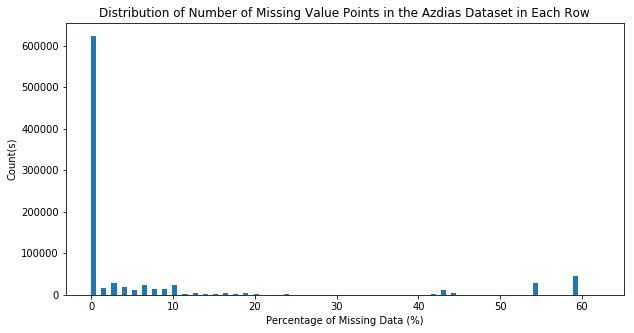

In [120]:
# How much data is missing in each row of the dataset?
null_number_row = azdias.isnull().sum(axis=1)

plt.figure(figsize=(10, 5))
plt.title('Distribution of Number of Missing Value Points in the Azdias Dataset in Each Row')
plt.hist(null_number_row / azdias.shape[1] * 100, bins=100)
plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Count(s)')
plt.show()

[Text(0,0.5,'Count(s)'), Text(0.5,0,'Percentage of Missing Data (%)')]

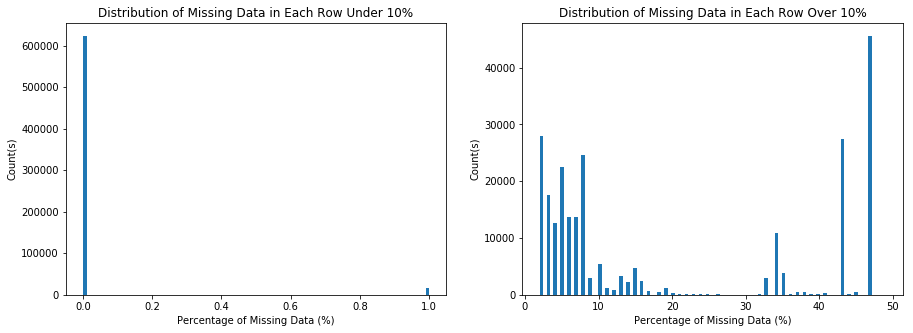

In [202]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Dividing dataset into two subsets by setting 1% as the threshold
row_data_under_1 = null_number_row.loc[(null_number_row / azdias.shape[1] * 100) <= 1]
row_data_over_1 = null_number_row.loc[(null_number_row / azdias.shape[1] * 100) > 1]
azdias_under_1 = azdias.loc[(null_number_row / azdias.shape[1] * 100) <= 1]
azdias_over_1 = azdias.loc[(null_number_row / azdias.shape[1] * 100) > 1]

fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

ax[0].hist(row_data_under_1, bins=100)
ax[1].hist(row_data_over_1, bins=100)
ax[0].set_title("Distribution of Missing Data in Each Row Under 10%")
ax[1].set_title("Distribution of Missing Data in Each Row Over 10%")
ax[0].set(xlabel="Percentage of Missing Data (%)", ylabel="Count(s)")
ax[1].set(xlabel="Percentage of Missing Data (%)", ylabel="Count(s)")

ALTERSKATEGORIE_GROB    2881
ANREDE_KZ                  0
CJT_GESAMTTYP           4854
FINANZ_MINIMALIST          0
FINANZ_SPARER              0
dtype: int64


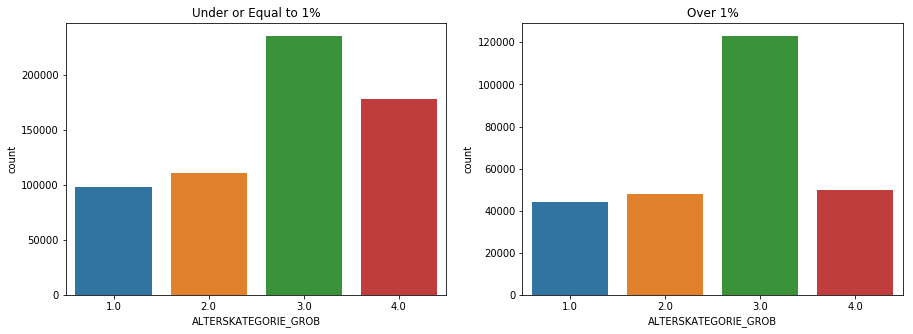

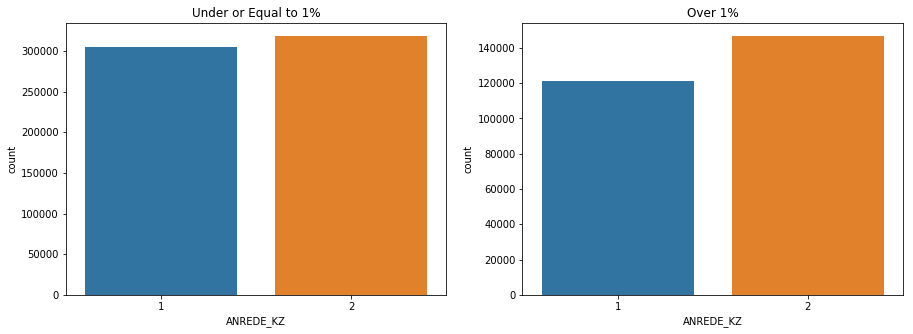

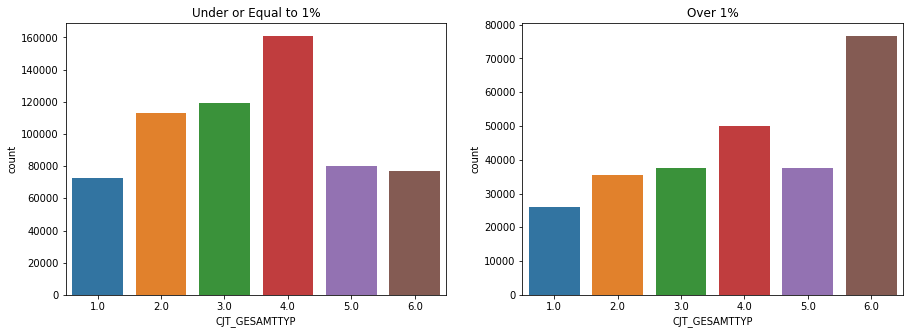

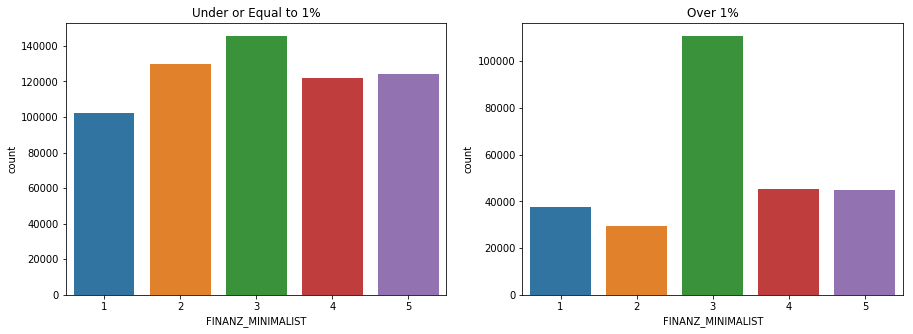

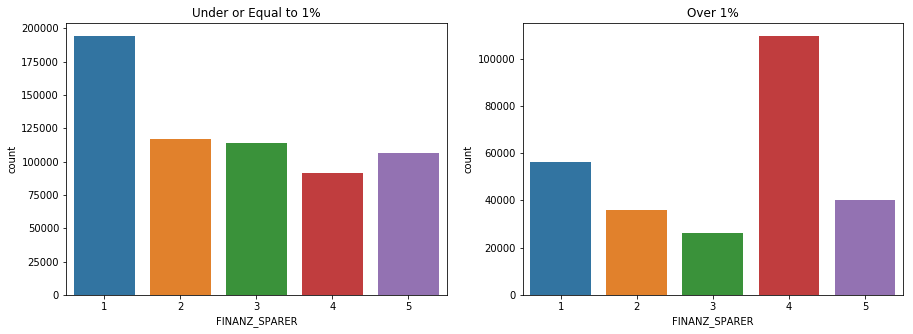

In [123]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Selecting the first 5 attributes with a few to no missing values
attri_under_1 = null_number.loc[(null_number / azdias.shape[0] * 100) <= 1]
print(attri_under_1.head())

def comparison_plot(col_name):
    fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)
    ax[0].set_title("Under or Equal to 1%")
    ax[1].set_title("Over 1%")
    sns.countplot(x=col_name, data=azdias_under_1, ax=ax[0])
    sns.countplot(x=col_name, data=azdias_over_1, ax=ax[1])

for a in ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER']:
    comparison_plot(a)

#### Discussion 1.1.3: Assess Missing Data in Each Row

From the distribution histogram I plotted in the first cell of step 1.1.3, we can see how the percentage of missing data for all of the attributes are under 60%. Using the threshold of 1%, we can compare different attributes to each one of the two subsets to see how similar or different they are to each subnet. I picked the following attributes with less than or equal to 1% of missing data as attributes to be compared: "ALTERSKATEGORIE_GROB", "ANREDE_KZ", "CJT_GESAMTTYP", "FINANZ_MINIMALIST", and "FINANZ_SPARER". From the comparison plots above, "FINANZ_MINIMALIST" and "FINANZ_SPARER" seem to look drastically different in the two subsets and so we know that each one of them is unique and can contribute to better results later in the analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [124]:
# How many features are there of each data type?
# Drop features from feat_info
outlier_cols = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
outlier_index = []
for c in outlier_cols:
    outlier_index.append(feat_info.index[feat_info['attribute'] == c][0])
feat_info = feat_info.drop(outlier_index)

numeric = feat_info[feat_info['type'] == 'numeric']
interval = feat_info[feat_info['type'] == 'interval']
ordinal = feat_info[feat_info['type'] == 'ordinal']
categorical = feat_info[feat_info['type'] == 'categorical']
mixed = feat_info[feat_info['type'] == 'mixed']
print("Number of numeric features: {}".format(len(numeric)))
print("Number of interval features: {}".format(len(interval)))
print("Number of ordinal features: {}".format(len(ordinal)))
print("Number of categorical features: {}".format(len(categorical)))
print("Number of mixed features: {}".format(len(mixed)))

Number of numeric features: 6
Number of interval features: 0
Number of ordinal features: 49
Number of categorical features: 18
Number of mixed features: 6


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

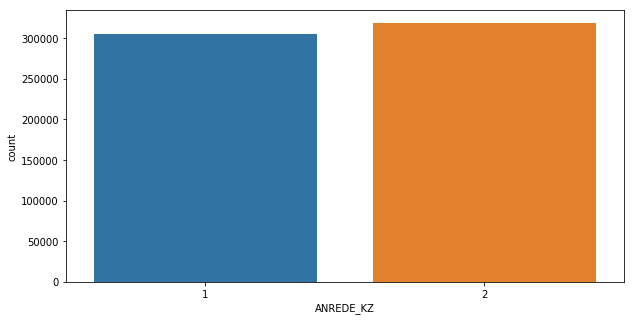

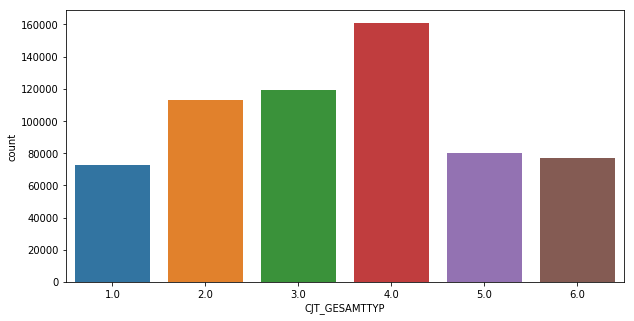

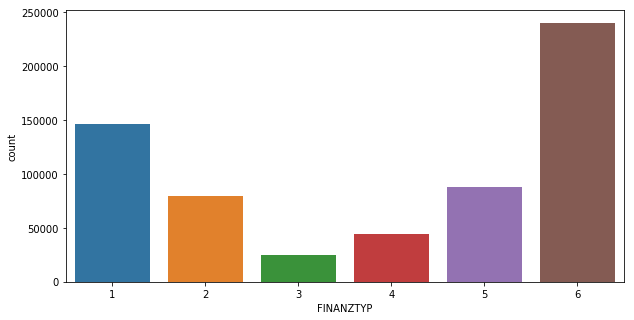

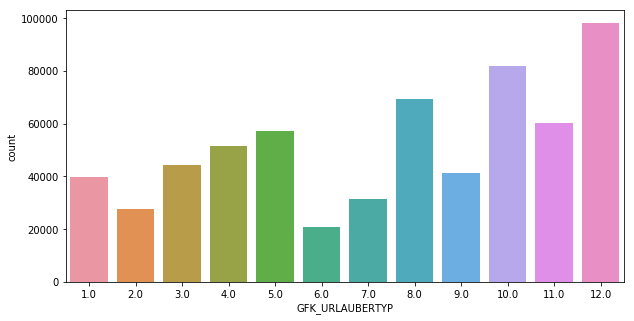

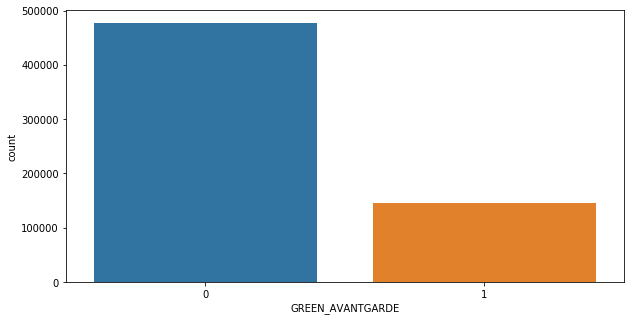

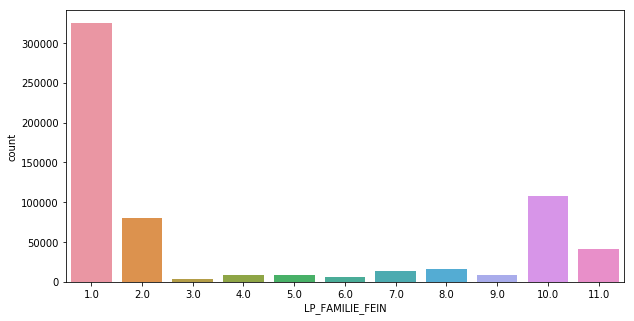

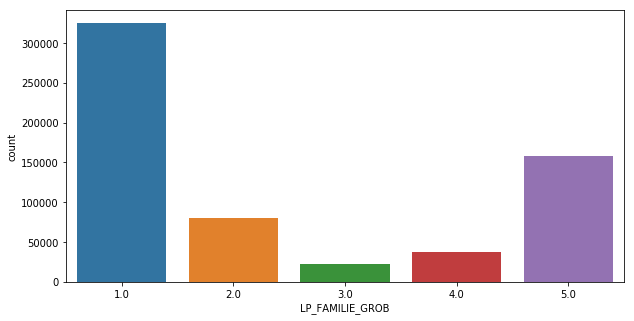

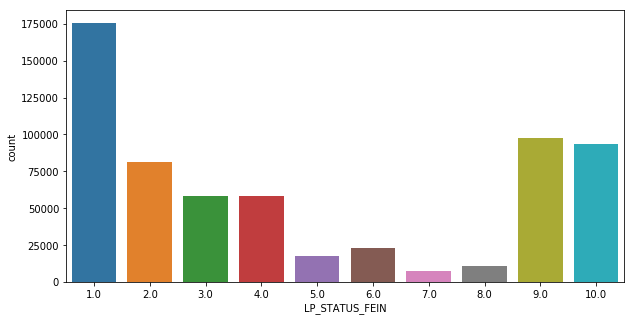

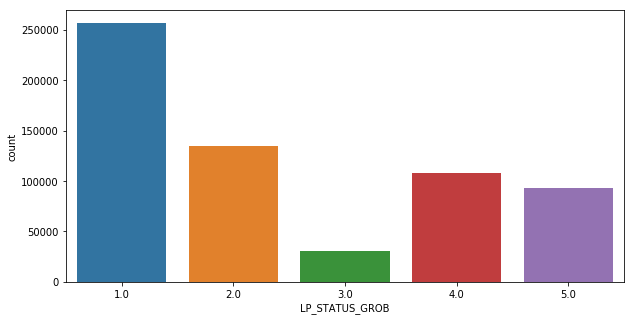

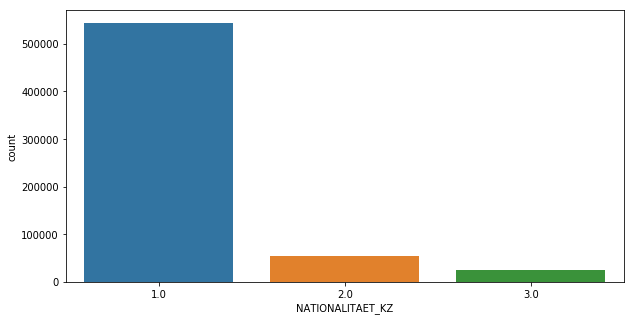

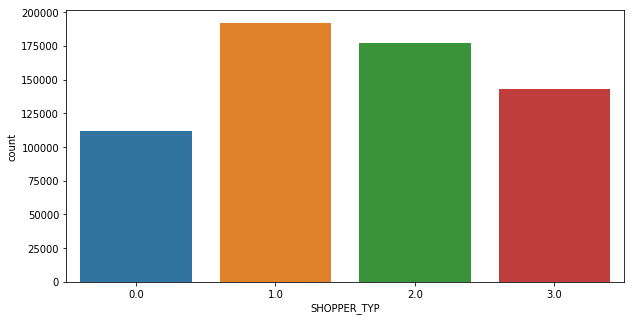

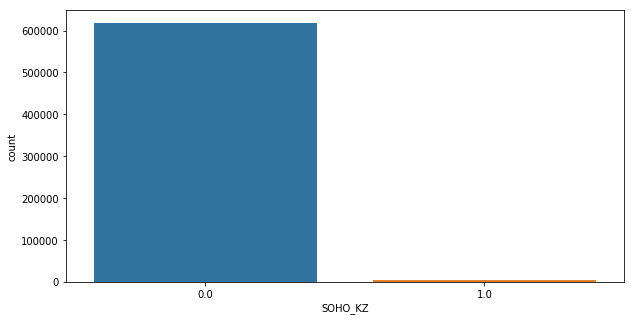

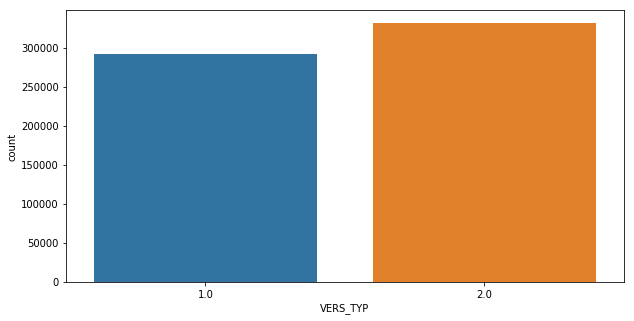

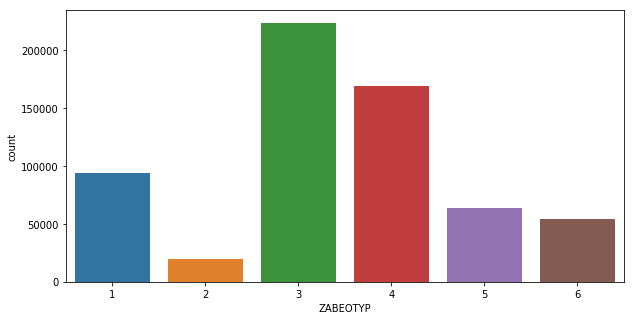

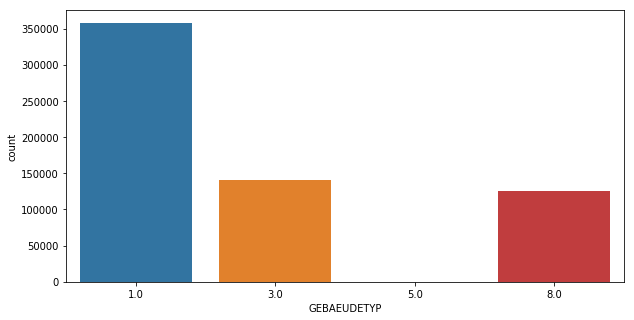

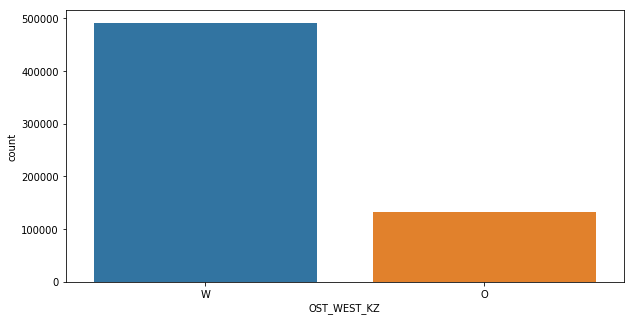

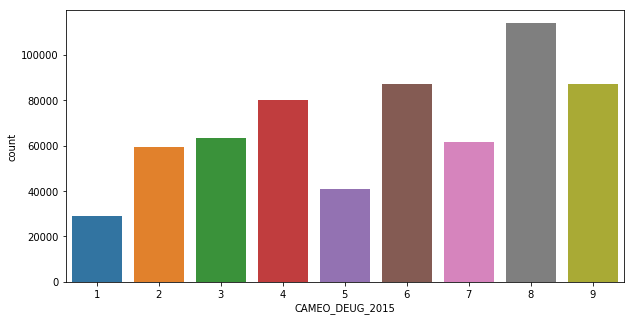

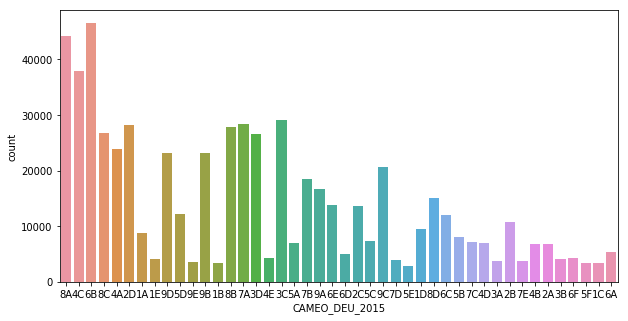

In [125]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
for a in list(categorical['attribute']):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.countplot(x=a, data=azdias_under_1, ax=ax) 
    plt.show()

In [126]:
# Re-encode categorical variable(s) to be kept in the analysis.
dummy_list = []
drop_list = []
for a in list(categorical['attribute']):
    if azdias_under_1[a].value_counts().shape[0] >= 3 and azdias_under_1[a].value_counts().shape[0] <= 6:
        dummy_list.append(a)
    elif azdias_under_1[a].value_counts().shape[0] > 6:
        drop_list.append(a)
dummy_list.append('OST_WEST_KZ')
print("Categorical attributes to create dummy variables for: {}".format(dummy_list))
print("Categorical attributes to be dropped: {}".format(drop_list))

Categorical attributes to create dummy variables for: ['CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ']
Categorical attributes to be dropped: ['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [ ]:
# Dummy variable creation
#azdias_under_1['OST_WEST_KZ'] = azdias_under_1['OST_WEST_KZ'].map({'W':0, 'O':1})
azdias_under_1 = pd.get_dummies(azdias_under_1, columns=dummy_list)

# Drop
azdias_drop = azdias_under_1.drop(drop_list, axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

From the various histograms shown above, we can see how many of the categorical attributes are multi-level. I created dummy variable for "OST_WEST_KZ", which is the only non-numeric binary categorical attribute in the dataset. I also created dummy variables for "CJT_GESAMTTYP", "FINANZTYP", "LP_FAMILIE_GROB", "LP_STATUS_GROB", "NATIONALITAET_KZ", "SHOPPER_TYP", and "ZABEOTYP", which have a range from 3 to 6 different values. Also, the attributes I dropped are "GFK_URLAUBERTYP", "LP_FAMILIE_FEIN", "LP_STATUS_FEIN", "CAMEO_DEUG_2015", and "CAMEO_DEU_2015", which have over 6 values.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

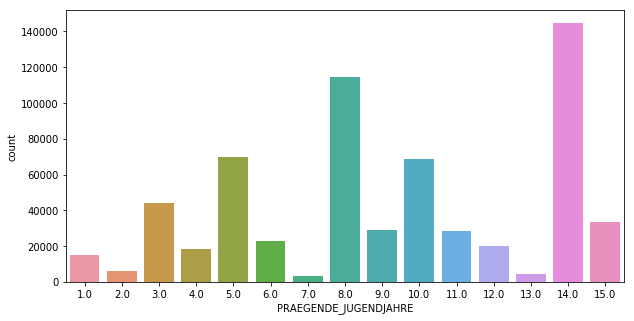

In [128]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Plotting 'PRAEGENDE_JUGENDJAHRE'
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x='PRAEGENDE_JUGENDJAHRE', data=azdias_drop, ax=ax) 
plt.show()

In [142]:
# Creating two new variables based on decade and movement
azdias_prag = azdias_drop['PRAEGENDE_JUGENDJAHRE']

azdias_drop.loc[azdias_prag == 1.0, 'Decade'] = '40s'
azdias_drop.loc[azdias_prag == 1.0, 'Movement'] = 'MainStream'

azdias_drop.loc[azdias_prag == 2.0, 'Decade'] = '40s'
azdias_drop.loc[azdias_prag == 2.0, 'Movement'] = 'Avantgarde'

azdias_drop.loc[azdias_prag == 3.0, 'Decade'] = '50s'
azdias_drop.loc[azdias_prag == 3.0, 'Movement'] = 'MainStream'

azdias_drop.loc[azdias_prag == 4.0, 'Decade'] = '50s'
azdias_drop.loc[azdias_prag == 4.0, 'Movement'] = 'Avantgarde'

azdias_drop.loc[azdias_prag == 5.0, 'Decade'] = '60s'
azdias_drop.loc[azdias_prag == 5.0, 'Movement'] = 'MainStream'

azdias_drop.loc[azdias_prag == 6.0, 'Decade'] = '60s'
azdias_drop.loc[azdias_prag == 6.0, 'Movement'] = 'Avantgarde'

azdias_drop.loc[azdias_prag == 7.0, 'Decade'] = '60s'
azdias_drop.loc[azdias_prag == 7.0, 'Movement'] = 'Avantgarde'

azdias_drop.loc[azdias_prag == 8.0, 'Decade'] = '70s'
azdias_drop.loc[azdias_prag == 8.0, 'Movement'] = 'MainStream'

azdias_drop.loc[azdias_prag == 9.0, 'Decade'] = '70s'
azdias_drop.loc[azdias_prag == 9.0, 'Movement'] = 'Avantgarde'

azdias_drop.loc[azdias_prag == 10.0, 'Decade'] = '80s'
azdias_drop.loc[azdias_prag == 10.0, 'Movement'] = 'MainStream'

azdias_drop.loc[azdias_prag == 11.0, 'Decade'] = '80s'
azdias_drop.loc[azdias_prag == 11.0, 'Movement'] = 'Avantgarde'

azdias_drop.loc[azdias_prag == 12.0, 'Decade'] = '80s'
azdias_drop.loc[azdias_prag == 12.0, 'Movement'] = 'MainStream'

azdias_drop.loc[azdias_prag == 13.0, 'Decade'] = '80s'
azdias_drop.loc[azdias_prag == 13.0, 'Movement'] = 'Avantgarde'

azdias_drop.loc[azdias_prag == 14.0, 'Decade'] = '90s'
azdias_drop.loc[azdias_prag == 14.0, 'Movement'] = 'MainStream'

azdias_drop.loc[azdias_prag == 15.0, 'Decade'] = '90s'
azdias_drop.loc[azdias_prag == 15.0, 'Movement'] = 'Avantgarde'  

In [143]:
# Encoding new attributes and dropping 'PRAEGENDE_JUGENDJAHRE'
azdias_drop = pd.get_dummies(azdias_drop, columns=['Decade', 'Movement'])
azdias_drop = azdias_drop.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

In [144]:
# New Dataset with Two New Attributes: 'Decade' and 'Movement' for 'PRAEGENDE_JUGENDJAHRE'
azdias_drop

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,OST_WEST_KZ_O,OST_WEST_KZ_W,Decade_40s,Decade_50s,Decade_60s,Decade_70s,Decade_80s,Decade_90s,Movement_Avantgarde,Movement_MainStream
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,1,0,0,0,0,0,1,0,1
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,1,0,0,0,0,0,1,1,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,1,0,0,0,1,0,0,0,1
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,1,0,1,0,0,0,0,0,1
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,1,0,0,0,0,1,0,0,1
7,1.0,1,3,3,4,1,3,2,0,1.0,...,0,1,0,0,0,1,0,0,0,1
8,3.0,1,4,4,2,4,2,2,1,3.0,...,0,1,0,0,0,0,1,0,1,0
9,3.0,2,2,4,2,3,5,4,1,2.0,...,0,1,0,0,0,0,0,1,1,0
10,3.0,2,2,2,5,3,1,5,0,2.0,...,0,1,0,1,0,0,0,0,0,1
19,3.0,1,5,2,3,1,3,1,1,3.0,...,0,1,0,0,0,1,0,0,1,0


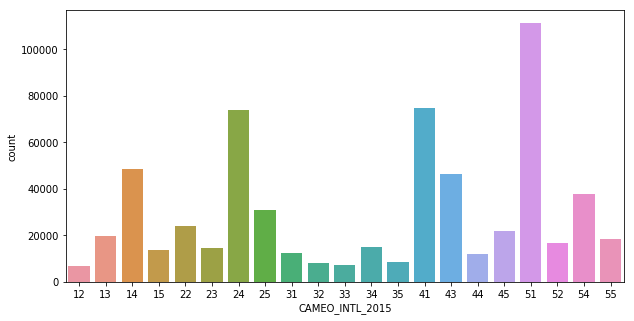

In [133]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Plotting 'CAMEO_INTL_2015'
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x='CAMEO_INTL_2015', data=azdias_drop, ax=ax) 
plt.show()

In [145]:
# Creating two new variables for 'CAMEO_INTL_2015'
azdias_cameo = azdias_drop['CAMEO_INTL_2015']

azdias_drop.loc[azdias_cameo.str[0] == '1', 'Wealth'] = 'Wealthy Households'
azdias_drop.loc[azdias_cameo.str[1] == '1', 'Life Stage'] = 'Pre-Family Couples & Singles'

azdias_drop.loc[azdias_cameo.str[0] == '2', 'Wealth'] = 'Prosperous Households'
azdias_drop.loc[azdias_cameo.str[1] == '2', 'Life Stage'] = 'Young Couples With Children'

azdias_drop.loc[azdias_cameo.str[0] == '3', 'Wealth'] = 'Comfortable Households'
azdias_drop.loc[azdias_cameo.str[1] == '3', 'Life Stage'] = 'Families With School Age Children'

azdias_drop.loc[azdias_cameo.str[0] == '4', 'Wealth'] = 'Less Affluent Households'
azdias_drop.loc[azdias_cameo.str[1] == '4', 'Life Stage'] = 'Older Families & Mature Couples'

azdias_drop.loc[azdias_cameo.str[0] == '5', 'Wealth'] = 'Poorer Households'
azdias_drop.loc[azdias_cameo.str[1] == '5', 'Life Stage'] = 'Elders In Retirement'

In [146]:
# Encoding new attributes and dropping 'CAMEO_INTL_2015'
azdias_drop = pd.get_dummies(azdias_drop, columns=['Wealth', 'Life Stage'])
azdias_drop = azdias_drop.drop('CAMEO_INTL_2015', axis=1)

In [147]:
# New Dataset with Two New Attributes: 'Wealth' and 'Life Stage' for 'CAMEO_INTL_2015'
azdias_drop

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,Wealth_Comfortable Households,Wealth_Less Affluent Households,Wealth_Poorer Households,Wealth_Prosperous Households,Wealth_Wealthy Households,Life Stage_Elders In Retirement,Life Stage_Families With School Age Children,Life Stage_Older Families & Mature Couples,Life Stage_Pre-Family Couples & Singles,Life Stage_Young Couples With Children
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,1,0,0,0,0,0,1,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,1,0,0,0,1,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,1,0,0,0,0,1,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,1,0,0,0,0,1,0,0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,1,0,0,0,0,0,1
7,1.0,1,3,3,4,1,3,2,0,1.0,...,0,0,0,0,1,0,0,1,0,0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,0,0,0,0,1,0,1,0,0,0
9,3.0,2,2,4,2,3,5,4,1,2.0,...,0,0,0,0,1,1,0,0,0,0
10,3.0,2,2,2,5,3,1,5,0,2.0,...,0,0,1,0,0,0,0,0,1,0
19,3.0,1,5,2,3,1,3,1,1,3.0,...,1,0,0,0,0,0,0,1,0,0


#### Discussion 1.2.2: Engineer Mixed-Type Features

For the "PRAEGENDE_JUGENDJAHRE" attribute, I first separated each value of the attribute into two variables: "Decade" and "Movement", and then created dummy variables for each value corresponding to the decade and movement associated to the decade for better analysis. I didn't create dummy variable for "East vs. West", but will create it if needed for better performance of the analysis later. Similarly, for the "CAMEO_INTL_2015" attribute, I separated each value of the attribute into two variables: "Wealth" and "Life Stage" by breaking up its 'tens'-place and 'ones'-place digits, and then create   

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

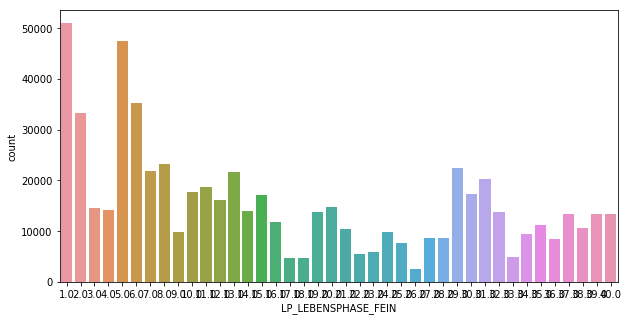

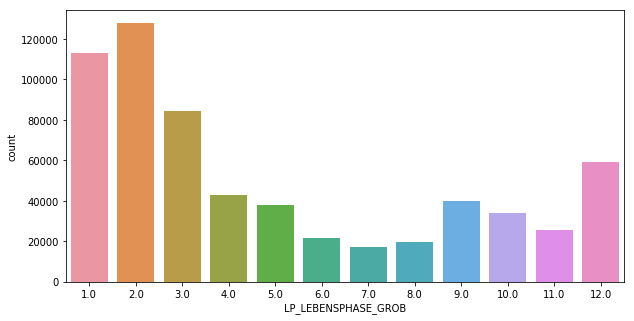

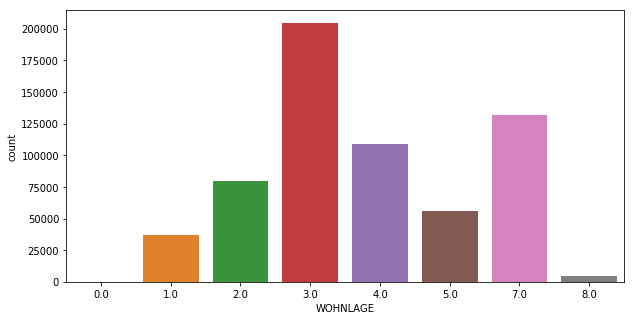

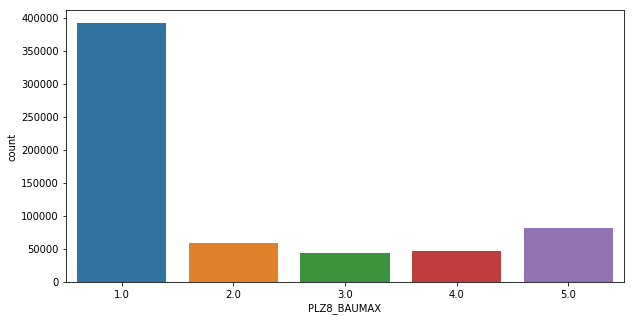

In [137]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
# Drop features from feat_info
outlier_cols = ["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015"]
outlier_index = []
for c in outlier_cols:
    outlier_index.append(feat_info.index[feat_info['attribute'] == c][0])
feat_info = feat_info.drop(outlier_index)
mixed = feat_info[feat_info['type'] == 'mixed']

# List of mixed attributes in the processed dataset
for a in list(mixed['attribute']):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.countplot(x=a, data=azdias_drop, ax=ax) 
    plt.show()

In [148]:
# Encode 'WOHNLAGE'
azdias_drop = pd.get_dummies(azdias_drop, columns=['WOHNLAGE'])

# Dropping mixed attributes that are repetitive and too vague
azdias_drop = azdias_drop.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX'], axis=1)

The data types in the dataset are the following: {dtype('int64'), dtype('uint8'), dtype('float64')}


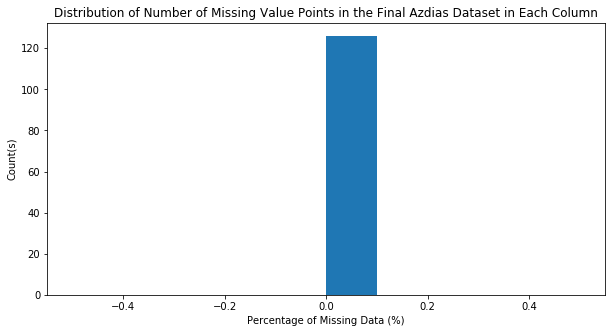

In [150]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
data_types = set(azdias_drop.dtypes)
print("The data types in the dataset are the following: {}".format(data_types))

nullSum = azdias_drop.isnull().sum()
plt.figure(figsize=(10, 5))
plt.title('Distribution of Number of Missing Value Points in the Final Azdias Dataset in Each Column')
plt.hist(nullSum / azdias_drop.shape[0] * 100, bins=10)
plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Count(s)')
plt.show()

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [210]:
# Creating new variables for attributes
def create_features(df, col_name):
    if col_name == 'PRAEGENDE_JUGENDJAHRE':
        df.loc[df[col_name] == 1.0, 'Decade'] = '40s'
        df.loc[df[col_name] == 1.0, 'Movement'] = 'MainStream'

        df.loc[df[col_name] == 2.0, 'Decade'] = '40s'
        df.loc[df[col_name] == 2.0, 'Movement'] = 'Avantgarde'

        df.loc[df[col_name] == 3.0, 'Decade'] = '50s'
        df.loc[df[col_name] == 3.0, 'Movement'] = 'MainStream'

        df.loc[df[col_name] == 4.0, 'Decade'] = '50s'
        df.loc[df[col_name] == 4.0, 'Movement'] = 'Avantgarde'

        df.loc[df[col_name] == 5.0, 'Decade'] = '60s'
        df.loc[df[col_name] == 5.0, 'Movement'] = 'MainStream'

        df.loc[df[col_name] == 6.0, 'Decade'] = '60s'
        df.loc[df[col_name] == 6.0, 'Movement'] = 'Avantgarde'

        df.loc[df[col_name] == 7.0, 'Decade'] = '60s'
        df.loc[df[col_name] == 7.0, 'Movement'] = 'Avantgarde'

        df.loc[df[col_name] == 8.0, 'Decade'] = '70s'
        df.loc[df[col_name] == 8.0, 'Movement'] = 'MainStream'

        df.loc[df[col_name] == 9.0, 'Decade'] = '70s'
        df.loc[df[col_name] == 9.0, 'Movement'] = 'Avantgarde'

        df.loc[df[col_name] == 10.0, 'Decade'] = '80s'
        df.loc[df[col_name] == 10.0, 'Movement'] = 'MainStream'

        df.loc[df[col_name] == 11.0, 'Decade'] = '80s'
        df.loc[df[col_name] == 11.0, 'Movement'] = 'Avantgarde'

        df.loc[df[col_name] == 12.0, 'Decade'] = '80s'
        df.loc[df[col_name] == 12.0, 'Movement'] = 'MainStream'

        df.loc[df[col_name] == 13.0, 'Decade'] = '80s'
        df.loc[df[col_name] == 13.0, 'Movement'] = 'Avantgarde'

        df.loc[df[col_name] == 14.0, 'Decade'] = '90s'
        df.loc[df[col_name] == 14.0, 'Movement'] = 'MainStream'

        df.loc[df[col_name] == 15.0, 'Decade'] = '90s'
        df.loc[df[col_name] == 15.0, 'Movement'] = 'Avantgarde'
        
        df = pd.get_dummies(df, columns=['Decade', 'Movement'])
        df = df.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
        
    elif col_name == 'CAMEO_INTL_2015':
        df.loc[df[col_name].str[0] == '1', 'Wealth'] = 'Wealthy Households'
        df.loc[df[col_name].str[1] == '1', 'Life Stage'] = 'Pre-Family Couples & Singles'

        df.loc[df[col_name].str[0] == '2', 'Wealth'] = 'Prosperous Households'
        df.loc[df[col_name].str[1] == '2', 'Life Stage'] = 'Young Couples With Children'

        df.loc[df[col_name].str[0] == '3', 'Wealth'] = 'Comfortable Households'
        df.loc[df[col_name].str[1] == '3', 'Life Stage'] = 'Families With School Age Children'

        df.loc[df[col_name].str[0] == '4', 'Wealth'] = 'Less Affluent Households'
        df.loc[df[col_name].str[1] == '4', 'Life Stage'] = 'Older Families & Mature Couples'

        df.loc[df[col_name].str[0] == '5', 'Wealth'] = 'Poorer Households'
        df.loc[df[col_name].str[1] == '5', 'Life Stage'] = 'Elders In Retirement'
        
        df = pd.get_dummies(df, columns=['Wealth', 'Life Stage'])
        df = df.drop('CAMEO_INTL_2015', axis=1)
        
    return df


In [211]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    for index, row in feat_info.iterrows():
        s = row['missing_or_unknown'][1:-1]
        if not s: 
            l = list(s)
        else:
            l = s.split(',')
        for val in l:
            if val == 'X' or val == 'XX':
                df[row['attribute']].replace(val, np.NaN, inplace=True)
            else:
                df[row['attribute']].replace(ast.literal_eval(val), np.NaN, inplace=True)
                
    # remove selected columns and rows, ...
    df = df.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis=1)
    null_number_row = df.isnull().sum(axis=1)
    df = df.loc[(null_number_row / df.shape[1] * 100) <= 1]
    outlier_cols = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    outlier_index = []
    for c in outlier_cols:
        outlier_index.append(feat_info.index[feat_info['attribute'] == c][0])
    feat_info = feat_info.drop(outlier_index)
    dummy_list = []
    drop_list = []
    for a in list(feat_info[feat_info['type'] == 'categorical']['attribute']):
        if df[a].value_counts().shape[0] >= 3 and df[a].value_counts().shape[0] <= 6:
            dummy_list.append(a)
        elif df[a].value_counts().shape[0] > 6:
            drop_list.append(a)
    dummy_list.append('OST_WEST_KZ')
    df = pd.get_dummies(df, columns=dummy_list)
    cleaned_df = df.drop(drop_list, axis=1)
    
    # select, re-encode, and engineer column values.
    cleaned_df = create_features(cleaned_df, 'PRAEGENDE_JUGENDJAHRE')
    cleaned_df = create_features(cleaned_df, 'CAMEO_INTL_2015')
    cleaned_df = pd.get_dummies(cleaned_df, columns=['WOHNLAGE'])
    cleaned_df = cleaned_df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX'], axis=1)
    
    # Return the cleaned dataframe.
    return cleaned_df


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [153]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imp = Imputer(missing_values=np.NaN, strategy='mean')
azdias_imp = pd.DataFrame(imp.fit_transform(azdias_drop))
azdias_imp.index = azdias_drop.index
azdias_imp.columns = azdias_drop.columns

In [154]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaler = scaler.fit_transform(azdias_imp.values)
azdias = pd.DataFrame(azdias_scaler, index=azdias_drop.index, columns=azdias_drop.columns)

In [155]:
# Compute number of missing data points in dataset
print("Number of missing data points in the dataset: {}".format(azdias.isnull().sum().sum()))

Number of missing data points in the dataset: 0


### Discussion 2.1: Apply Feature Scaling

I used the "Imputer" and "StandardScaler" instances to both impute and scale my dataset. The imputation method I used for the missing data values is to calculate the mean of each column/attribute and replace the missing data values with the mean in each column. For scaling, I scaled every column in the dataset to have the mean of 0 and standard deviation of 1. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [156]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
azdias_fit = pca.fit_transform(azdias)

In [157]:
def scree_plot(pca, df, n=None):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    if n:
        for i in np.arange(0, ceil(n), 10):
            ax.annotate(r"%s%%" % ((str(cumvals[i]*100)[:4])), (ind[i] , cumvals[i] + 0.02), va="bottom", ha="center", fontsize=12)
    else:
        for i in np.arange(0, ceil(df.shape[1]), 10):
            ax.annotate(r"%s%%" % ((str(cumvals[i]*100)[:4])), (ind[i] , cumvals[i] + 0.02), va="bottom", ha="center", fontsize=12)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

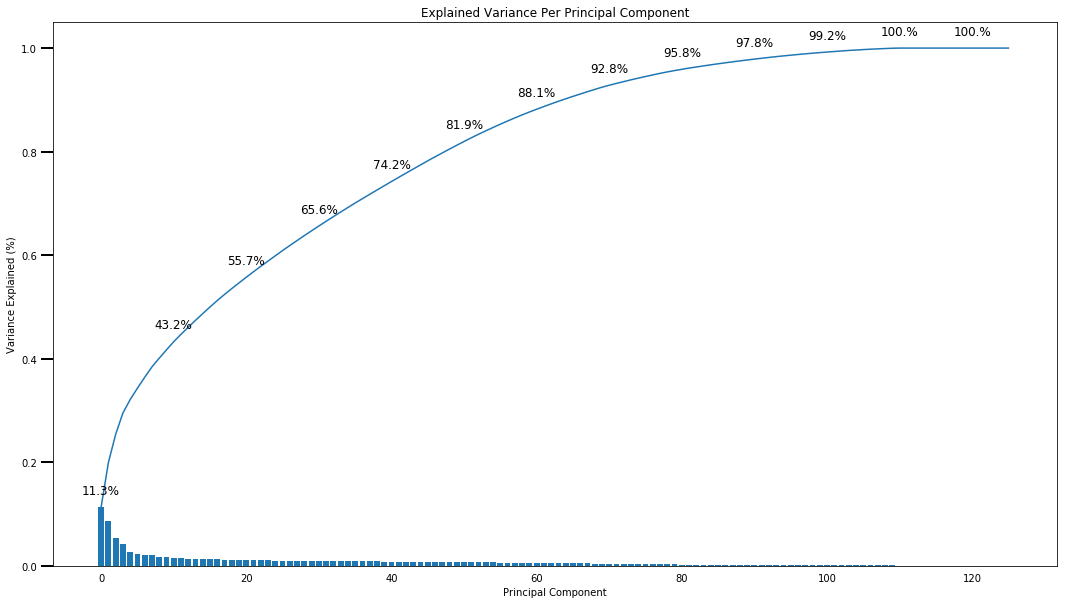

In [158]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca, azdias)

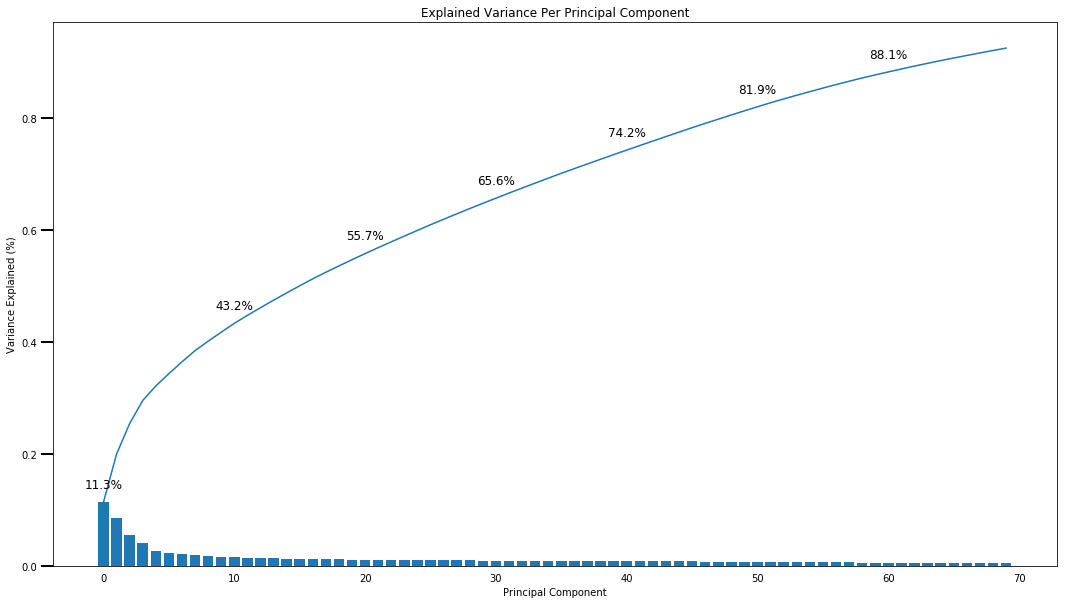

In [159]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=70)
azdias_fit = pca.fit_transform(azdias)
scree_plot(pca, azdias, 70)

### Discussion 2.2: Perform Dimensionality Reduction

I chose 70 as my number of principal components to use, because it is the saturation point where there is a decreased positive slope on the variance curve. From the scree plots plotted above, we can see that the variance curve starts to saturate at 70 principal components, and having 70 principal components also provides us with a variance of around 92.7%. However, I will increase the number of principal components to be used if needed for better performance of the analysis in the future.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [160]:
def plot_heatmap(components):
    fig, ax = plt.subplots(figsize = (15,10))
    ax = sns.heatmap(components)

def component_weights(n, pca, df):
    components = pd.DataFrame(np.round(pca.components_[n-1:n], 4), index=['Feature Weights'], columns=df.columns)
    components = components.sort_values(by='Feature Weights', axis=1, ascending=False).T
    print(components)
    return components
    

                                            Feature Weights
LP_STATUS_GROB_1.0                                   0.1943
HH_EINKOMMEN_SCORE                                   0.1803
PLZ8_ANTG3                                           0.1789
PLZ8_ANTG4                                           0.1741
ORTSGR_KLS9                                          0.1537
FINANZ_SPARER                                        0.1533
EWDICHTE                                             0.1503
Wealth_Poorer Households                             0.1429
Life Stage_Pre-Family Couples & Singles              0.1359
FINANZ_HAUSBAUER                                     0.1322
FINANZTYP_1                                          0.1310
KBA05_ANTG4                                          0.1259
SEMIO_PFLICHT                                        0.1194
PLZ8_ANTG2                                           0.1181
ARBEIT                                               0.1154
KBA05_ANTG3                             

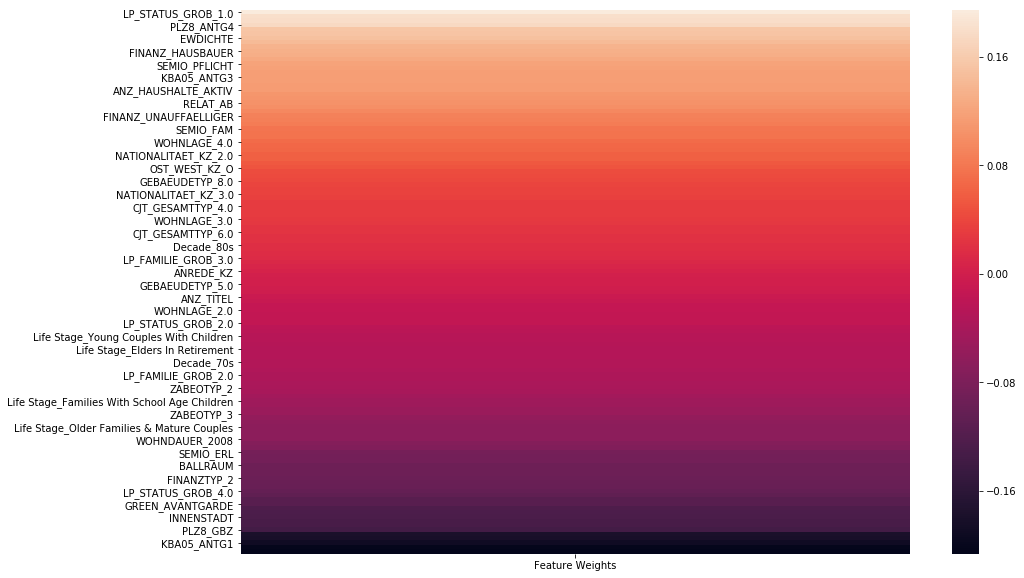

In [161]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
components = component_weights(1, pca, azdias)
plot_heatmap(components)

                          Feature Weights
ALTERSKATEGORIE_GROB               0.2179
ZABEOTYP_3                         0.2002
FINANZ_VORSORGER                   0.1976
SEMIO_ERL                          0.1861
RETOURTYP_BK_S                     0.1532
SEMIO_LUST                         0.1489
W_KEIT_KIND_HH                     0.1222
FINANZ_HAUSBAUER                   0.1186
Decade_60s                         0.1073
PLZ8_ANTG3                         0.1063
PLZ8_ANTG4                         0.1022
ORTSGR_KLS9                        0.0976
Decade_50s                         0.0974
EWDICHTE                           0.0961
CJT_GESAMTTYP_2.0                  0.0957
SEMIO_KRIT                         0.0947
FINANZTYP_5                        0.0882
SEMIO_KAEM                         0.0817
ARBEIT                             0.0777
KBA05_ANTG4                        0.0761
Wealth_Poorer Households           0.0739
SHOPPER_TYP_3.0                    0.0722
LP_FAMILIE_GROB_1.0               

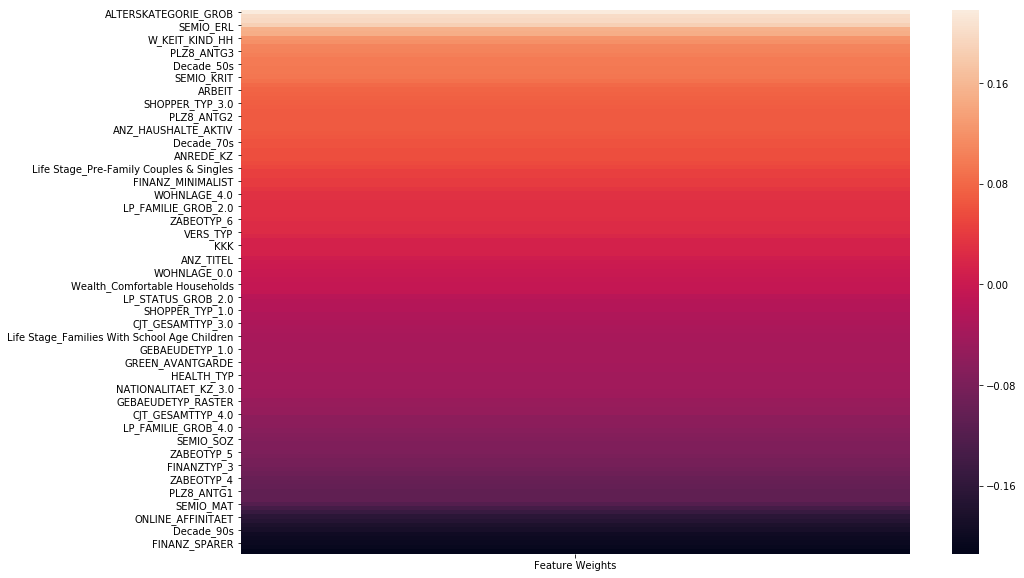

In [162]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
components = component_weights(2, pca, azdias)
plot_heatmap(components)

                              Feature Weights
SEMIO_VERT                             0.3212
SEMIO_SOZ                              0.2537
SEMIO_FAM                              0.2514
SEMIO_KULT                             0.2343
FINANZTYP_5                            0.1481
FINANZ_MINIMALIST                      0.1327
SHOPPER_TYP_0.0                        0.1252
ZABEOTYP_1                             0.1150
SEMIO_REL                              0.1038
RETOURTYP_BK_S                         0.0934
Movement_Avantgarde                    0.0876
GREEN_AVANTGARDE                       0.0876
W_KEIT_KIND_HH                         0.0782
EWDICHTE                               0.0766
ORTSGR_KLS9                            0.0765
SEMIO_MAT                              0.0720
FINANZ_VORSORGER                       0.0634
LP_STATUS_GROB_5.0                     0.0589
PLZ8_ANTG3                             0.0582
PLZ8_ANTG4                             0.0575
ZABEOTYP_6                        

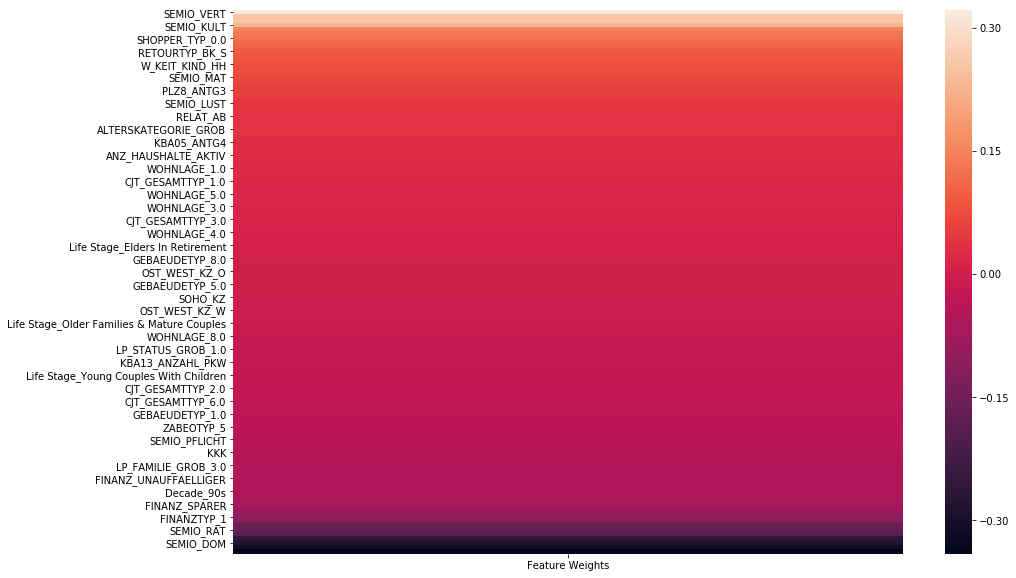

In [163]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
components = component_weights(3, pca, azdias)
plot_heatmap(components)

### Discussion 2.3: Interpret Principal Components

From the weights calculated and heatmaps generated for the first few principal components, the top and end feature weights appear to be different for different number of principal components. 

With the first principal component, the attributes "LP_STATUS_GROB_1.0" and "FINANZ_MINIMALIST" are inversely related to each other because of their opposite weights of 0.1943 and -0.2073 respectively. Based on "Data_Dictionary.md", the negative correlation between the two attributes makes sense, because since "LP_STATUS_GROB_1.0" represents low-income earners, "FINANZ_MINIMALIST" that represents people with low financial interest can't be low-income earners to lead a minimalist lifestyle.

With the second principal component, the attributes "ALTERSKATEGORIE_GROB" and "SEMIO_REL" are inversely related to each other because of their opposite weights of 0.2170 and -0.2133 respectively. There is a negative correlation between the two attributes, because "ALTERSKATEGORIE_GROB" which represents the age demographics of the population and "SEMIO_REL" which represents how religious the population is don't affect each other since age doesn't matter when it comes to being how religious someone is.

With the third principal component, the attributes "SEMIO_VERT" and "ANREDE_KZ" are inversely related to each other because of their opposite weights of 0.3211 and -0.3409 respectively. "SEMIO_VERT" that represents how dreamful the population and "ANREDE_KZ" that represents the gender of the population have a negative correlation, because gender doesn't matter when it comes to how dreamful someone is.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [43]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...    
# compute the average within-cluster distances.
k = [i+1 for i in range(20)]
scores = []

for i in k:
    kmeans = KMeans(n_clusters=i)
    model = kmeans.fit(azdias_fit)
    scores.append(abs(model.score(azdias_fit)))
    
print(scores)

[72578729.204931602, 65909463.435380019, 62227160.922286399, 60117028.238738529, 58382412.172199026, 57150767.392302677, 56082704.69134365, 55274591.299783669, 54655456.263721898, 54060461.312487327, 53584829.516878597, 53074182.197087169, 52675012.343463182, 52170834.420572259, 51626956.704773717, 51295539.319775596, 50942481.466520987, 50423424.168252215, 50018707.587771975, 49886706.412849948]


Text(0.5,1,'Avg. Distance Error vs. K')

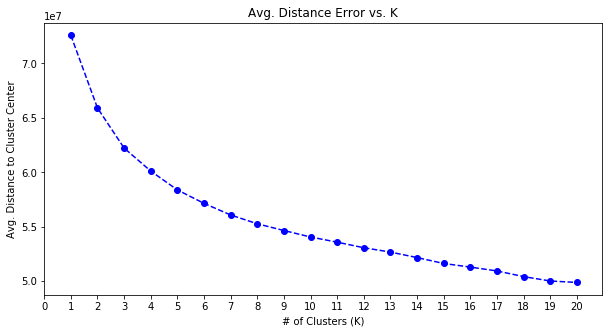

In [56]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(10,5))
plt.plot(k, scores, linestyle='--', marker='o', color='b')
plt.xticks(np.arange(0, 21, 1))
plt.xlabel('# of Clusters (K)')
plt.ylabel('Avg. Distance to Cluster Center')
plt.title('Avg. Distance Error vs. K')

In [164]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(14)
labels = kmeans.fit_predict(azdias_fit)

### Discussion 3.1: Apply Clustering to General Population

Using the Elbow Method with 1 to 20 possible number of clusters, I was able to obtain 14 as the most optimal number of clusters for kmeans, because it is estimated to be the "elbow" point where the average distance to the cluster centers starts to saturate after that point. I was able to obtain cluster predictions using the KMeans instance.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [232]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [200]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

In [233]:
# Clean data (preprocessing)
customers = clean_data(customers)
for col in customers:
    print(col)

ALTERSKATEGORIE_GROB
ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
GREEN_AVANTGARDE
HEALTH_TYP
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
SOHO_KZ
VERS_TYP
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
KONSUMNAEHE
MIN_GEBAEUDEJAHR
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_HHZ
PLZ8_GBZ
ARBEIT
ORTSGR_KLS9
RELAT_AB
CJT_GESAMTTYP_1.0
CJT_GESAMTTYP_2.0
CJT_GESAMTTYP_3.0
CJT_GESAMTTYP_4.0
CJT_GESAMTTYP_5.0
CJT_GESAMTTYP_6.0
FINANZTYP_1
FINANZTYP_2
FINANZTYP_3
FINANZTYP_4
FINANZTYP_5
FINANZTYP_6
LP_FAMILIE_GROB_1.0
LP_FAMILIE_GROB_2.0
LP_FAMILIE_GROB_3.0
LP_FAMILIE_GROB_4.0
LP_FAM

In [234]:
# Customer dataset missing attributes: 'GEBAEUDETYP_5.0' and 'WOHNLAGE_1.0' so I'm inserting them with 0 values
customers.insert(customers.columns.get_loc('GEBAEUDETYP_8.0'), 'GEBAEUDETYP_5.0', 0)
customers.insert(customers.columns.get_loc('WOHNLAGE_1.0'), 'WOHNLAGE_0.0', 0)

In [235]:
# Feature imputation
customers_imp = pd.DataFrame(imp.transform(customers))
customers_imp.index = customers.index
customers_imp.columns = customers.columns

# Feature scaling
customers_scaler = scaler.transform(customers_imp.values)
customers = pd.DataFrame(customers_scaler, index=customers.index, columns=customers.columns)

# Dimensionality reduction with PCA
customers_tf = pca.transform(customers)

In [236]:
# Use fitted KMeans model to predict clusters based on customers dataset
customer_labels = model.predict(customers_tf)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [244]:
# Converting predicted labels to dataframes
labels_df = pd.DataFrame(labels, index=range(len(labels)), columns=['Labels'])
c_labels_df = pd.DataFrame(customer_labels, index=range(len(customer_labels)), columns=['Labels'])

In [304]:
# Plotting function for convenience 
def plot_dist(df1, df2):
    fig, ax = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
    ax[0].set_title("Distribution of Number of People in the Population in Each Cluster")
    ax[1].set_title("Distribution of Number of Customers in Each Cluster")
    sns.barplot(x='Labels', y='Labels', data=df1, ax=ax[0], estimator=lambda x: len(x) / len(df1) * 100)
    sns.barplot(x='Labels', y='Labels', data=df2, ax=ax[1], estimator=lambda x: len(x) / len(df2) * 100)
    ax[0].set(ylabel="Percentage(%)")
    ax[1].set(ylabel="Percentage(%)")

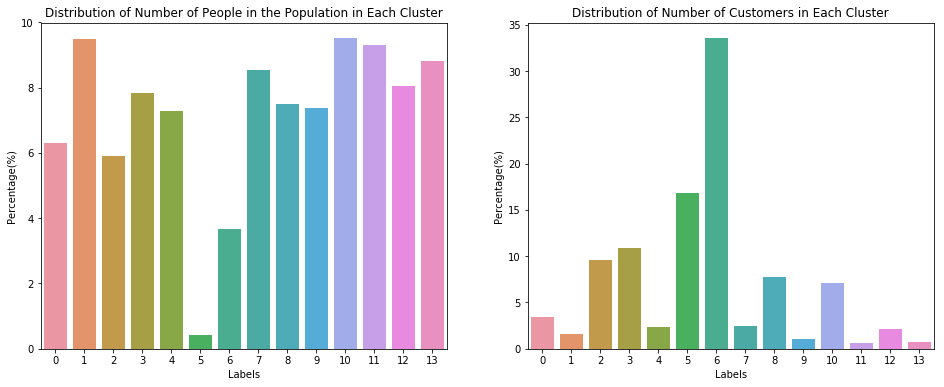

In [297]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
plot_dist(labels_df, c_labels_df)

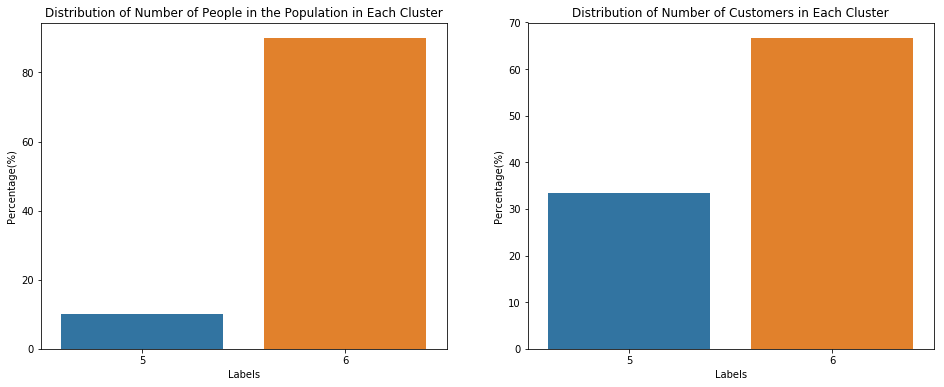

In [399]:
# Selecting two most different clusters compared to the rest of the clusters
out = labels_df.loc[(labels_df['Labels'] == 6) | (labels_df['Labels'] == 5)]
c_out = c_labels_df.loc[(c_labels_df['Labels'] == 6) | (c_labels_df['Labels'] == 5)]
plot_dist(out, c_out)

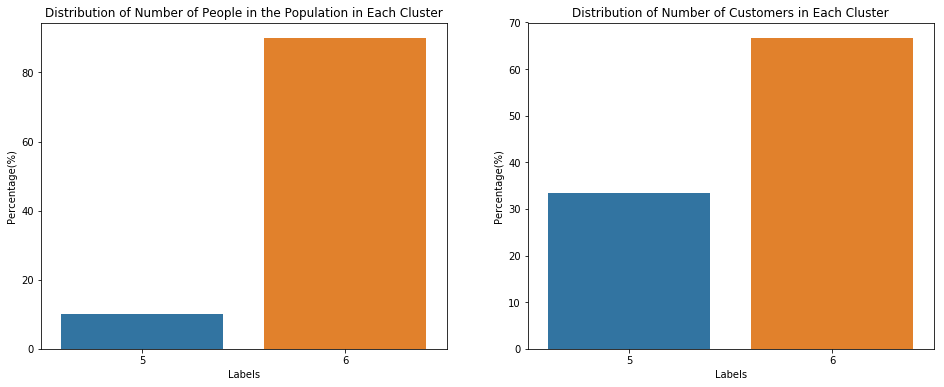

In [378]:
# Selecting two most overrepresented customer data compared to the general popupalation
new_labels = labels_df.loc[(labels_df['Labels'] == 6) | (labels_df['Labels'] == 5)]
new_c_labels = c_labels_df.loc[(c_labels_df['Labels'] == 6) | (c_labels_df['Labels'] == 5)]
plot_dist(new_labels, new_c_labels)

In [379]:
# Returns top 3 attributes most correlated to component
def component_to_attributes(n, pca, df):
    components = pd.DataFrame(np.round(pca.components_[n-1:n], 4), index=['Feature Weights'], columns=df.columns)
    components = components.sort_values(by='Feature Weights', axis=1, ascending=False).T
    return components[0:3]

# Plotting function for convenience 
def plot_attributes(df1, df2, label, c1, c2):
    fig, ax = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
    ax[0].set_title("Distribution of Attributes Most Correlated to Label {} (Population, Component {})".format(label, c1))
    ax[1].set_title("Distribution of Attributes Most Correlated to Label {} (Customer, Component {})".format(label, c2))
    sns.barplot(x=df1.index, y='Feature Weights', data=df1, ax=ax[0])
    sns.barplot(x=df2.index, y='Feature Weights', data=df2, ax=ax[1])
    ax[0].set(xlabel="Attributes")
    ax[1].set(xlabel="Attributes")

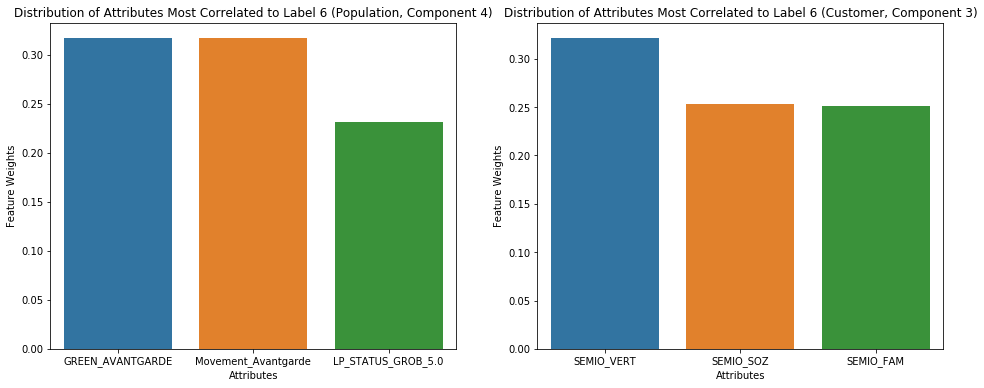

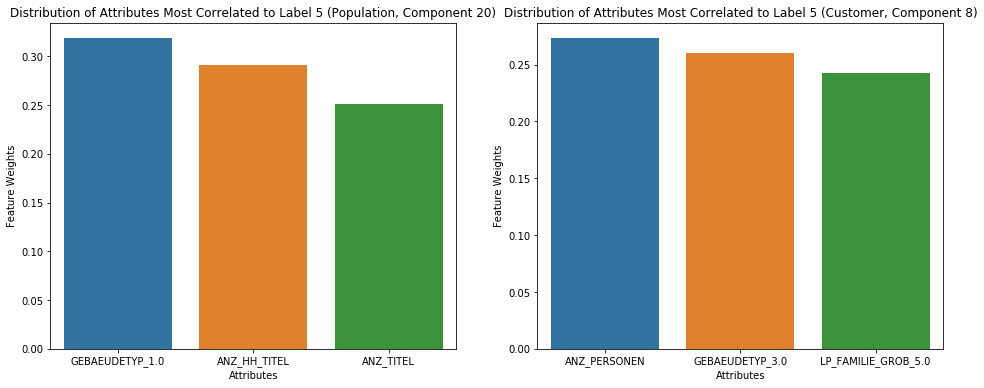

In [388]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Converting PCA models to dataframes
components = ['Component {}'.format(i) for i in range(1,len(pca.components_)+1)]
azdias_pca_df = pd.DataFrame(azdias_fit, columns=components)
customer_pca_df = pd.DataFrame(customers_tf, columns=components)

# Finding indices for label 6 and 5
indice6_a = new_labels.index[new_labels['Labels'] == 6].tolist()
indice5_a = new_labels.index[new_labels['Labels'] == 5].tolist()
indice6_c = new_c_labels.index[new_c_labels['Labels'] == 6].tolist()
indice5_c = new_c_labels.index[new_c_labels['Labels'] == 5].tolist()

# Selecting most weighted component for each label
component_a = azdias_pca_df.iloc[list(new_labels.index)]
topAComponent6 = component_a.loc[indice6_a].idxmax(axis=1).value_counts().idxmax()
topAComponent5 = component_a.loc[indice5_a].idxmax(axis=1).value_counts().idxmax()
component_c = customer_pca_df.iloc[list(new_c_labels.index)]
topCComponent6 = component_c.loc[indice6_c].idxmax(axis=1).value_counts().idxmax()
topCComponent5 = component_c.loc[indice5_c].idxmax(axis=1).value_counts().idxmax()

# Selecting attributes most correlated to top component
a1 = component_to_attributes(int(topAComponent6[10:]), pca, azdias)
a2 = component_to_attributes(int(topAComponent5[10:]), pca, azdias)
a3 = component_to_attributes(int(topCComponent6[10:]), pca, customers)
a4 = component_to_attributes(int(topCComponent5[10:]), pca, customers)

# Plotting distribution of attributes most correlated to top component
plot_attributes(a1, a3, 6, int(topAComponent6[10:]), int(topCComponent6[10:]))
plot_attributes(a2, a4, 5, int(topAComponent5[10:]), int(topCComponent5[10:]))

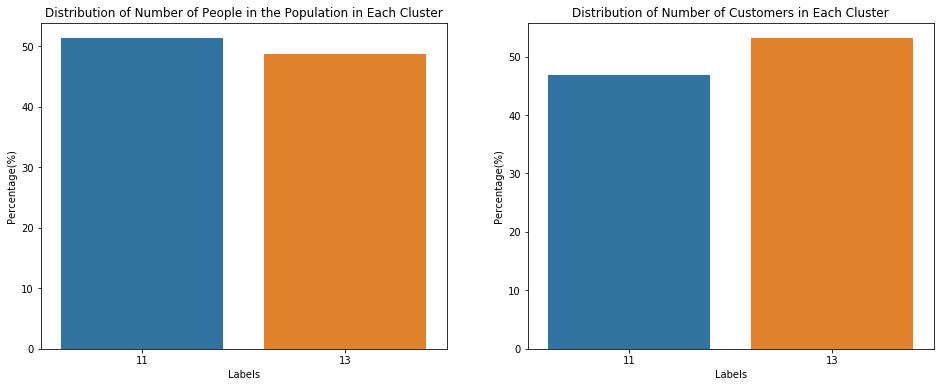

In [391]:
# Selecting two underrepresented in the customer data compared to the general popupaltion
new_labels = labels_df.loc[(labels_df['Labels'] == 13) | (labels_df['Labels'] == 11)]
new_c_labels = c_labels_df.loc[(c_labels_df['Labels'] == 13) | (c_labels_df['Labels'] == 11)]
plot_dist(new_labels, new_c_labels)

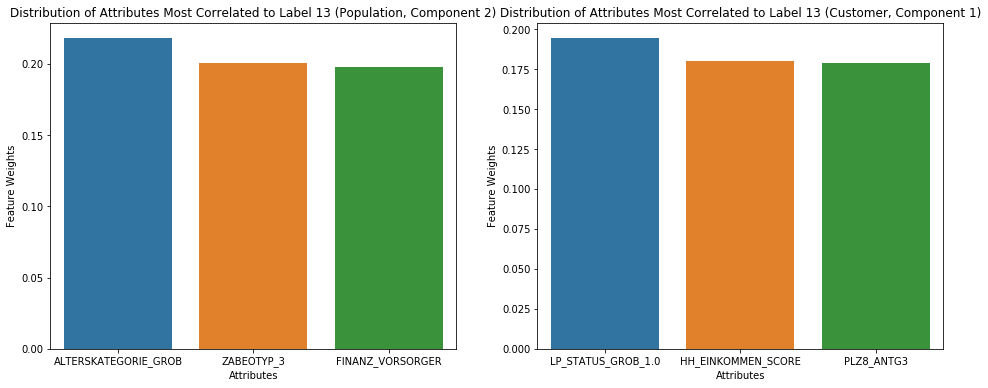

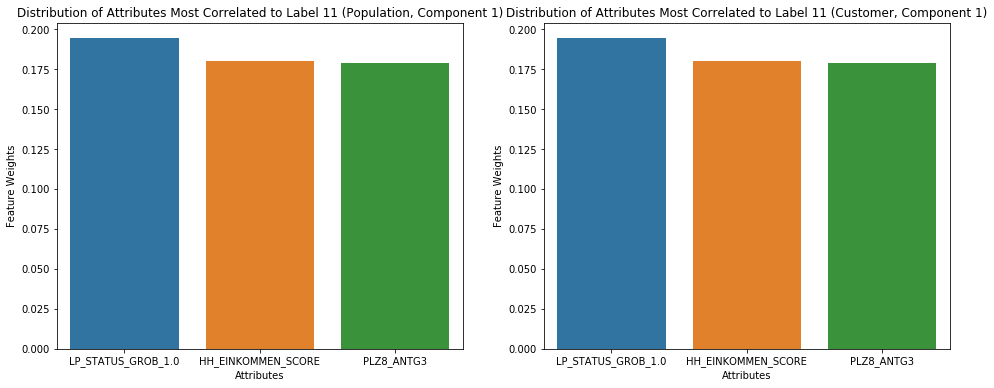

In [392]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Converting PCA models to dataframes
components = ['Component {}'.format(i) for i in range(1,len(pca.components_)+1)]
azdias_pca_df = pd.DataFrame(azdias_fit, columns=components)
customer_pca_df = pd.DataFrame(customers_tf, columns=components)

# Finding indices for label 13 and 11
indice13_a = new_labels.index[new_labels['Labels'] == 13].tolist()
indice11_a = new_labels.index[new_labels['Labels'] == 11].tolist()
indice13_c = new_c_labels.index[new_c_labels['Labels'] == 13].tolist()
indice11_c = new_c_labels.index[new_c_labels['Labels'] == 11].tolist()

# Selecting most weighted component for each label
component_a = azdias_pca_df.iloc[list(new_labels.index)]
topAComponent13 = component_a.loc[indice13_a].idxmax(axis=1).value_counts().idxmax()
topAComponent11 = component_a.loc[indice11_a].idxmax(axis=1).value_counts().idxmax()
component_c = customer_pca_df.iloc[list(new_c_labels.index)]
topCComponent13 = component_c.loc[indice13_c].idxmax(axis=1).value_counts().idxmax()
topCComponent11 = component_c.loc[indice11_c].idxmax(axis=1).value_counts().idxmax()

# Selecting attributes most correlated to top component
a1 = component_to_attributes(int(topAComponent13[10:]), pca, azdias)
a2 = component_to_attributes(int(topAComponent11[10:]), pca, azdias)
a3 = component_to_attributes(int(topCComponent13[10:]), pca, customers)
a4 = component_to_attributes(int(topCComponent11[10:]), pca, customers)

# Plotting distribution of attributes most correlated to top component
plot_attributes(a1, a3, 13, int(topAComponent13[10:]), int(topCComponent13[10:]))
plot_attributes(a2, a4, 11, int(topAComponent11[10:]), int(topCComponent11[10:]))

### Discussion 3.3: Compare Customer Data to Demographics Data

Based on the clustering analysis I have done, the labels/clusters that seem to be drastically different between the population and customer data are labels 5 and 6. To separate the two labels into one cluster, I set the thresholds as 4% and 15%, which represents the number of people in each cluster, for the population and customer dataset respectively. Anything below 4% would be one cluster for the population dataset, whereas anything above 15% would be one cluster.

To answer the question about what segments of the population that are relatively popular with the mail-order company, we need to take a look at the cluster in the customer data that is overrepresented compared to the general population. Labels 5 and 6 are the two overrepresented clusters I found in the customer data. By choosing the maximum number of frequencies a certain component shows up in each of the two labels, I could make use of the information regarding the correlation between each component to each attribute in step 2.3 to help me understand what kind of people/attributes in the general population are more likely to choose the mail-order company over other companies. Based on the principal components interpretation in step 2.3, I was able to find that the people with attributes: "GREEN AVANTGARDE", "Movement_Avantgarde", "LP_STATUS_GROB_5.0", "SEMIO_VERT", "SEMIO_SOZ", "SEMIO_FAM", "GEBAEUDETYP_1.0", "ANZ_HH_TITEL", "ANZ_TITEL", "ANZ_PERSONEN", and "GEBAEUDETYP_3.0" are more popular with the mail-order company. Even though the number of attributes might seem misleading, they actually point to interesting traits found in people who use the mail-order company more. Based on the attributes, we can say that segments of the population that are popular with the mail-order company tend to be more wealthy, family-oriented, educated, socially-aware due to involvements in movements, and living in residential and commercial buildings.

On the other hand, after looking at attributes found in segments that are more popular with the mail-order company, we can easily point out attributes found in people who are unpopular with the company, and the clusters I found that are associated with these kind of people are labels 11 and 13. Luckily, the histogram distribution I graphed shows a pretty consistent list of attributes found in segments unpopular with the company, such as "LP_STATUS_GROB_1.0", "HH_EINKOMMEN_SCORE", "PLZ8_ANTG3", "ALTERSKATEGORIE_GROB", "ZABEOTYP_3", and "FINANZ_VORSORGER". In summary, almost opposite to the attributes found in segments popular with the company, the attributes interpreted amongst people that are unpopular with the company tend to be poorer, less engaged in social movements, and have conservative views on finance.   

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.